## NGN/USD Exchange Rate Forecasting

## Introduction

The foreign exchange (forex) market is a decentralized global platform for the trading of currencies, enabling international trade, investment, and financial transactions. One of the most closely monitored currency pairs in Nigeria is the exchange rate between the Nigerian Naira (₦) and the United States Dollar (USD), given the dollar's dominance in global commerce and finance. The USD/NGN exchange rate serves as a critical indicator of Nigeria’s macroeconomic stability, trade competitiveness, and investors confidence.

### Problem Statement

Over the past decade, the Nigerian Naira has experienced persistent volatility and depreciation against the US Dollar. This instability is driven by structural imbalances such as heavy dependence on oil exports, low foreign reserve buffers, restricted access to foreign exchange, and macroeconomic policy uncertainty. The resulting exchange rate unpredictability creates considerable challenges for economic planning, foreign direct investment, inflation control, and business sustainability. The absence of a reliable forecast mechanism further complicates strategic decision-making for both the public and private sectors.Therefore, it is useful to model the Naira-to-Dollar exchange rate series with the aim of understanding its historical behavior and projecting its future trajectory. The focus is on the exchange rate time series itself, independent of underlying economic drivers.


### Importance of Forecasting the USD/NGN Exchange Rate

Forecasting the future exchange rate is of significant interest to several stakeholders:

- **Government and Policy Makers**: Exchange rate forecasts are critical for formulating monetary and fiscal policies, especially in managing inflation, foreign reserves, and external debt obligations. Accurate projections can enhance macroeconomic planning and credibility.
  
- **Investors and Financial Institutions**: Both domestic and foreign investors require forward-looking exchange rate insights for portfolio allocation, risk management, and profit repatriation decisions. Financial institutions also rely on these forecasts for pricing currency derivatives and hedging exposure.

- **Importers and Exporters**: Businesses engaged in international trade depend on stable and predictable exchange rates to manage procurement costs, revenue expectations, and contract negotiations. Exchange rate uncertainty can erode profit margins and increase operational risks.

- **Multinational Corporations (MNCs)**: MNCs operating in Nigeria face translation and transaction exposure due to exchange rate fluctuations. Knowing the likely direction of the Naira helps them in budgeting, repatriation strategies, and cost optimization.

- **Households and Remittance Recipients**: For Nigerian households reliant on imported goods or foreign remittances, fluctuations in the exchange rate directly affect purchasing power and consumption patterns. Forecasts help in personal financial planning and safeguarding household welfare.

### Conclusion

Given the widespread relevance of the Naira/USD exchange rate across sectors, modeling the exchange rate series provides a practical approach to understanding its patterns and forecasting its future values. By focusing on the historical behavior of the series, a data-driven model can generate projections that inform planning, investment decisions, and exposure management without requiring detailed knowledge of underlying economic factors.

## Research Methodology

This study adopts a quantitative research design, focusing on the application of multiple machine learning algorithms to model and forecast the Naira to US Dollar (₦/$) exchange rate as a univariate time series. The methodology involves the following key steps:

### 1. Data Collection

Weekly historical exchange rate data (₦/$) will be sourced from Investing.com. The data will be cleaned, properly indexed by date, and reviewed for consistency and completeness to ensure it is suitable for time series modeling.

### 2. Data Preprocessing
The dataset will be transformed into a suitable structure for time series modeling. This will include:
- Handling missing values, if any
- Ensuring correct date indexing
- Converting the raw series into supervised learning format by creating lagged features
- Applying optional transformations (e.g., log transformation or differencing) where necessary to stabilize variance or achieve stationarity

### 3. Model Selection
Multiple machine learning algorithms will be applied to model the exchange rate series. These include:
- **Linear Regression**: For baseline performance and interpretability
- **Decision Tree Regressor**: For capturing non-linear relationships in the lagged structure
- **Random Forest Regressor**: An ensemble method to improve predictive accuracy and reduce variance
- **Gradient Boosting Machines (e.g., XGBoost, LightGBM)**: For performance comparison using advanced boosting techniques
- **Support Vector Regressor (SVR)**: For robustness to outliers and handling high-dimensional lag structures

Each model will be trained using lagged features derived from the time series to predict the next-day exchange rate.

### 4. Model Evaluation
The models will be evaluated using appropriate time series cross-validation techniques (e.g., expanding or rolling window) to ensure the temporal order is preserved. Performance metrics will include:
- Mean Absolute Error (MAE)
- Root Mean Square Error (RMSE)
- Mean Absolute Percentage Error (MAPE)

These metrics will be used to compare the predictive performance of the models.

### 5. Forecasting and Visualization
The best-performing model(s) will be used to generate short-term forecasts of the exchange rate. Forecasts will be visualized alongside actual values to assess prediction accuracy and identify any systematic deviations.

### 6. Interpretation and Documentation
The results will be interpreted based on model performance rather than economic theory, given the focus on the time series behavior of the exchange rate. A discussion of the practical implications of the forecasts for various stakeholders (e.g., investors, policymakers, businesses) will be included.

This methodological approach enables a purely data-driven examination of the Naira/USD exchange rate, leveraging machine learning to produce reliable forecasts without depending on external macroeconomic variables.

## Analysis

In [ ]:
import sys
import os

# Go up one level to reach the project root
sys.path.append(os.path.abspath('..'))

In [ ]:
# loading the data
from exchange_rate_model.module import load_data_from_db

df = load_data_from_db("C:/Users/USER/Documents/AKIN/PROJECTS/exchange_rate_model/data/exchange_rate_data.db",
                              table_name="ngn_usd_data")
df.head(5)

,exchange_rate
date,
2019-01-06,306.88
2019-01-13,306.80
2019-01-20,306.78
2019-01-27,306.70
2019-02-03,305.70


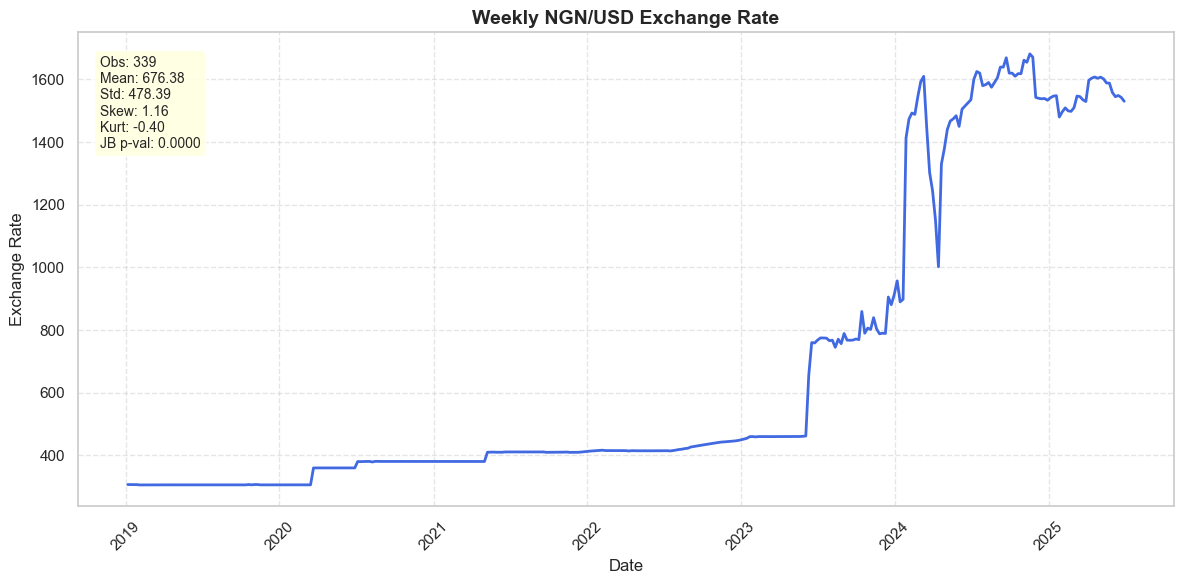

In [ ]:
# Descriptive analysis
from exchange_rate_model.module import summarize_with_plot
desc_analysis = summarize_with_plot(df)
desc_analysis

In [8]:
# logging exchange rate and creates 4 lags
from exchange_rate_model.module import log_and_lag

log_lag_df = log_and_lag(df, n_lags = 4)
log_lag_df

,exchange_rate,exchange_rate_lag_1,exchange_rate_lag_2,exchange_rate_lag_3,exchange_rate_lag_4
date,,,,,
2019-02-03,5.722604,5.725870,5.726131,5.726196,5.726457
2019-02-10,5.722768,5.722604,5.725870,5.726131,5.726196
2019-02-17,5.722931,5.722768,5.722604,5.725870,5.726131
2019-02-24,5.722931,5.722931,5.722768,5.722604,5.725870
2019-03-03,5.723258,5.722931,5.722931,5.722768,5.722604
...,...,...,...,...,...
2025-06-01,7.351261,7.370199,7.370621,7.378808,7.382261
2025-06-08,7.342702,7.351261,7.370199,7.370621,7.378808
2025-06-15,7.345113,7.342702,7.351261,7.370199,7.370621


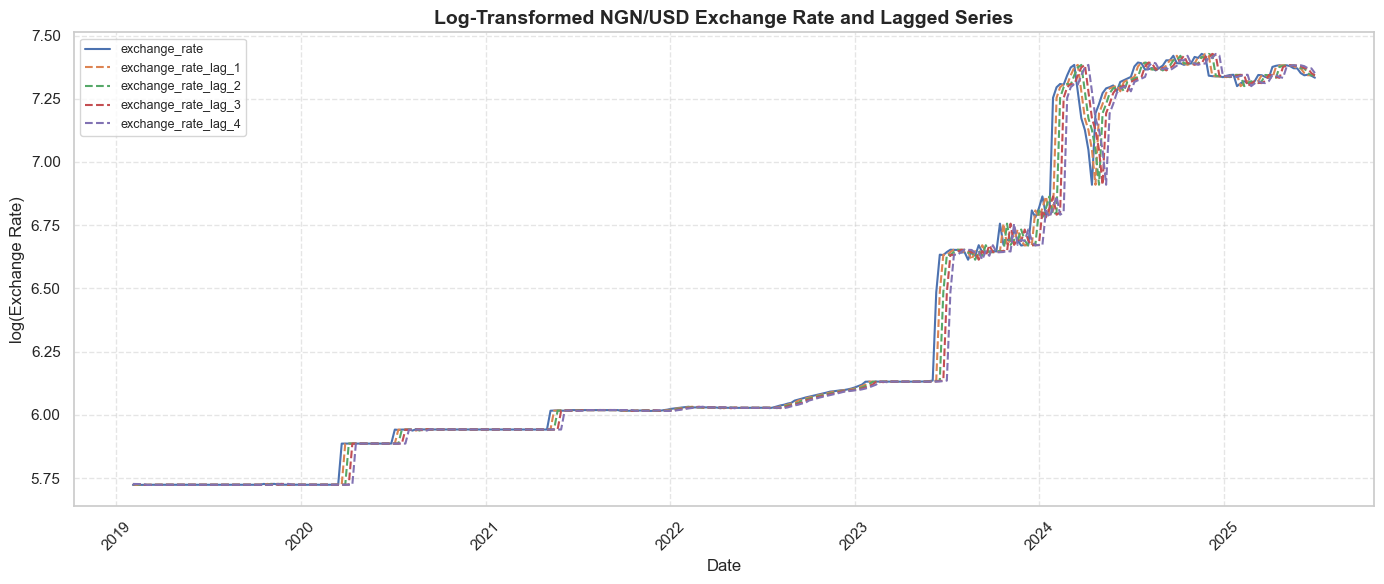

In [9]:
# Plotting the logged and lagged exchange rate series
from exchange_rate_model.module import plot_logged_series

plot_logged_series(log_lag_df)

In [10]:
# Splitting log and lagged series into target and features and training and test considering time
from exchange_rate_model.module import time_series_split

X_train_df, X_test_df, y_train_df, y_test_df = time_series_split(log_lag_df, "exchange_rate")

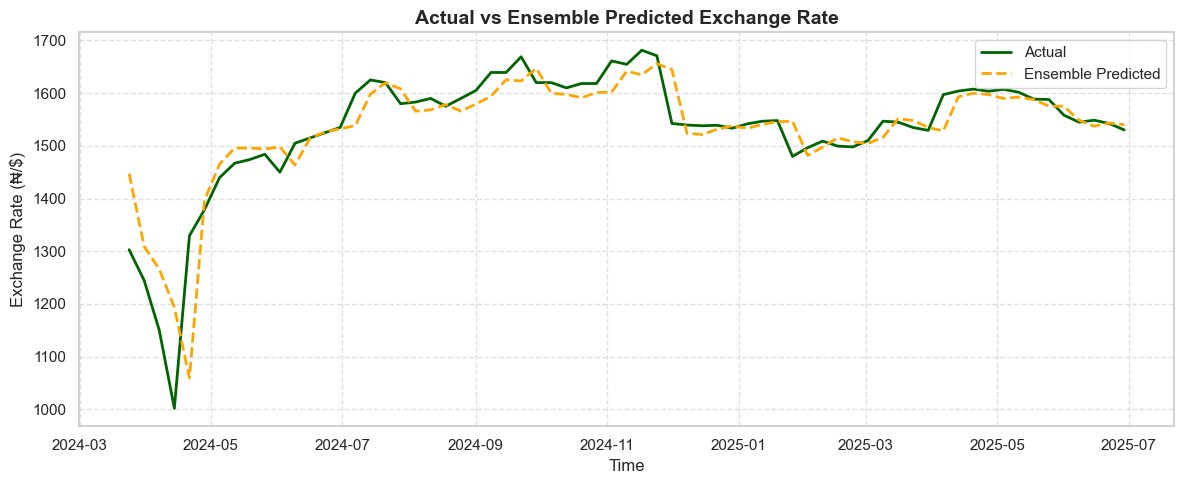

Evaluation Metrics:
MAE: 30.6781
RMSE: 54.345
R2: 0.7776


In [11]:
# Finally training the ensemble model

from exchange_rate_model.module import ensemble_lasso_linear_lstm
results = ensemble_lasso_linear_lstm(X_train_df, y_train_df, X_test_df, y_test_df)

print("Evaluation Metrics:")
for k, v in results.items():
    if k in ["MAE", "RMSE", "R2"]:
        print(f"{k}: {v}")